Dependencies

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from wordcloud import WordCloud
import string

Task 1


In [13]:
df = pd.read_csv("AB_NYC_2019.csv")
df["last_review"] = df["last_review"].fillna("N/A")
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

In the dataset we can see that for the listings with 0 reviews, the columns "last_review" are "reviews_per_month" are left with blank or NaN values in the dataframe. In order to avoid issues later on when doing things like aggregation or getting errors when trying to view elements in the df, I replaced all the NaN values in the "last_review" column with the string "N/A" using df["last_review"].fillna("N/A"). I then filled the NaN values in the "reviews_per_month" column with 0 using df["reviews_per_month"].fillna(0), as that will be a column that is used for aggregation purposed in the future and if there were no reviwes conducted on this property, then there would also be zero reviews per month.

Task 2


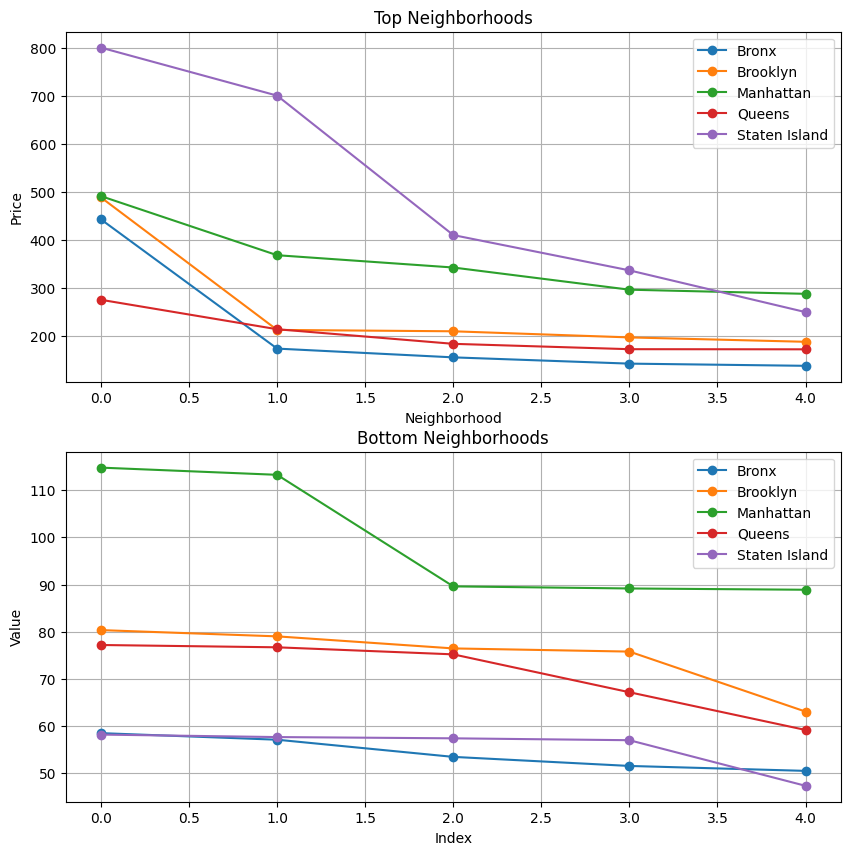

In [14]:
# group the neighborhoods by their "neighborhood_group" column
neighborhood_groups = df.groupby("neighbourhood_group")

top_bottom_group = []

#initialize empty arrays to hold the top and bottom neighborhoods for each group
tops = []
bottoms = []

for group_name, group_df in neighborhood_groups:

    # We get the avg price for each neighborhood within a given neighborhood group
    avg_neighborhood_price = group_df.groupby("neighbourhood")["price"].mean()
    sorted_neighborhoods = avg_neighborhood_price.sort_values(ascending=False)

    # we then get the top and bottom five neighborhoods from there after sorting by price
    tops.append((group_name, sorted_neighborhoods.head(5).tolist()))
    bottoms.append((group_name, sorted_neighborhoods.tail(5).tolist()))


fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plotting the tops list in the first subplot
for row in tops:
    axs[0].plot(row[1], marker='o')

axs[0].set_title('Top Neighborhoods')
axs[0].set_xlabel('Neighborhood')
axs[0].set_ylabel('Price')
axs[0].legend([f'{tops[i][0]}' for i in range(len(tops))], loc='upper right')
axs[0].grid(True)

# Plotting the bottoms list in the second subplot
for row in bottoms:
    axs[1].plot(row[1], marker='o')

axs[1].set_title('Bottom Neighborhoods')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].legend([f'{bottoms[i][0]}' for i in range(len(bottoms))], loc='upper right')
axs[1].grid(True)

plt.show()

From the graphs, we can see that for the top neighborhoods in each Neighborhood group, Staten Island was consistently the most expensive, followed by Mnahattan and he rest of the neighborhood groups were quite similar. When we then look at the bottom neighborhoods in each neighborhood group, we can see that the most consistently expensive one was Manhattan and Staten Island is now towards the less expensive side - showing the difference in patterns as the price of the neighborhoods changes

Task 3


Top 3 Postive correlations:
        Feature 1            Feature 2  Correlation
19        Reviews        Reviews/Month     0.589407
37  Host Listings  Availability (Days)     0.225701
21        Reviews  Availability (Days)     0.172028


Top 3 Negative Correlations:
        Feature 1      Feature 2  Correlation
7       Price ($)      Longitude    -0.150019
11     Min Nights  Reviews/Month    -0.124905
39  Host Listings      Longitude    -0.114713


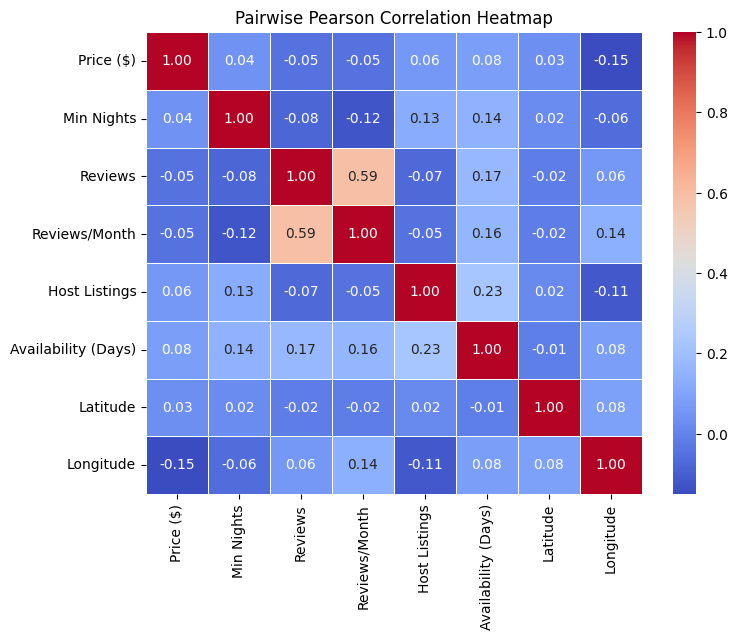

In [15]:
column_names = ["price", "minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365", "latitude", "longitude"]

# this will make a df containing all of the features
features_df = df[column_names]

rename_dict = {
    "price": "Price ($)",
    "minimum_nights": "Min Nights",
    "number_of_reviews": "Reviews",
    "reviews_per_month": "Reviews/Month",
    "calculated_host_listings_count": "Host Listings",
    "availability_365": "Availability (Days)",
    "latitude": "Latitude",
    "longitude": "Longitude"

}

new_features = features_df.rename(columns=rename_dict)

# this will create the confusion matrix including all of the features
corr_matrix = new_features.corr(method='pearson')

corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

# removing self correlation and duplicate values
corr_pairs = corr_pairs[corr_pairs['Feature 1'] != corr_pairs['Feature 2']]
corr_pairs = corr_pairs.drop_duplicates(subset=['Correlation'], keep='first')

# getting the top and bottom 3 correlations
top_positive = corr_pairs.nlargest(3, 'Correlation')
top_negative = corr_pairs.nsmallest(3, 'Correlation')

print("Top 3 Postive correlations:")
print(top_positive)
print('\n')
print("Top 3 Negative Correlations:")
print(top_negative)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Pairwise Pearson Correlation Heatmap")
plt.show()

Task 4


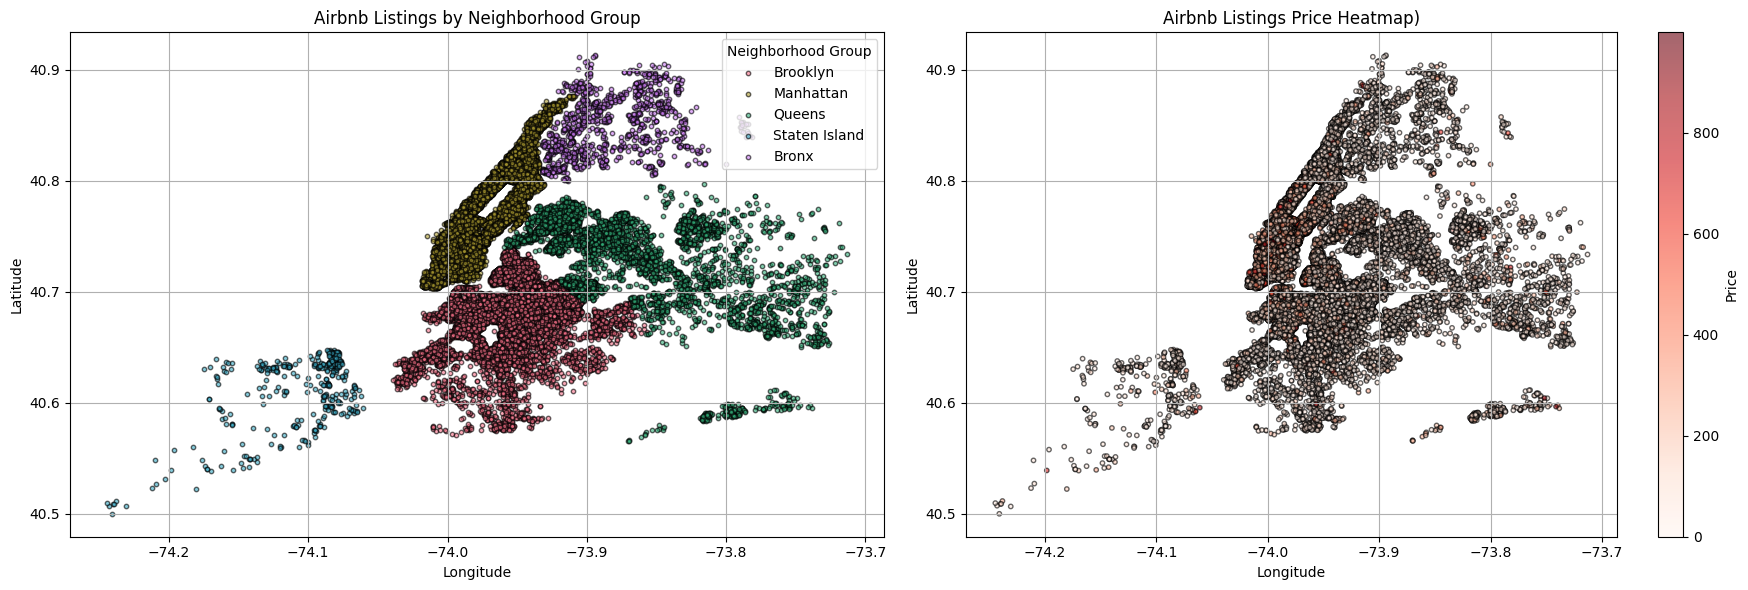

In [16]:
# Get all the neighborhood groups
unique_groups = df["neighbourhood_group"].unique()

# Get distinct colors for the number of neighborhood groups we have
palette = sns.color_palette("husl", len(unique_groups))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for color, group in zip(palette, unique_groups):
    subset = df[df["neighbourhood_group"] == group]
    axes[0].scatter(subset["longitude"], subset["latitude"],
                    label=group, color=color, alpha=0.6, edgecolors='black', s=10)

# get the airbnbs with price less than 1000
subset_price = df[df["price"] < 1000]

# normalize the prices such that low is low intensity of red and high is high intensity of red
norm = mcolors.Normalize(vmin=subset_price["price"].min(), vmax=subset_price["price"].max())

# red colormap
cmap = plt.cm.Reds

scatter = axes[1].scatter(subset_price["longitude"], subset_price["latitude"],
                          c=subset_price["price"], cmap=cmap, norm=norm,
                          alpha=0.6, edgecolors='black', s=10)

# color bar on the side to show levels of instensity
fig.colorbar(scatter, ax=axes[1], label="Price")

axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].set_title("Airbnb Listings by Neighborhood Group")
axes[0].legend(title="Neighborhood Group", loc="upper right")
axes[0].grid(True)

axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].set_title("Airbnb Listings Price Heatmap)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

From the price heatmap on the right we can see that the Manhattan Neighborhood Group is the most expensive as it has a more saturated coloration than the other groups


Task 5

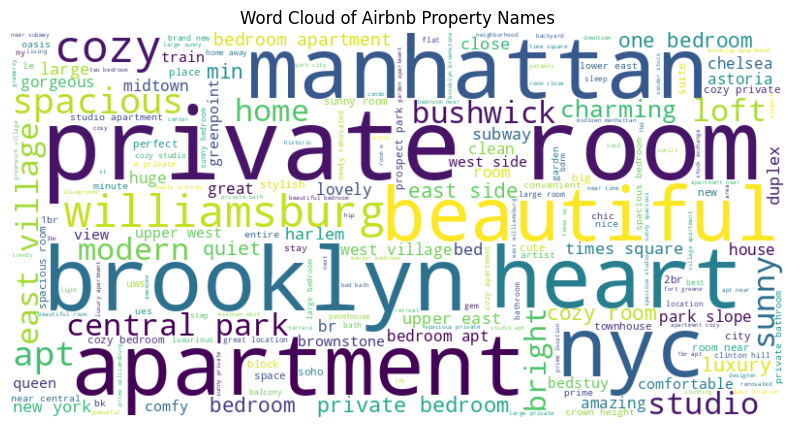

In [17]:
# this removes any NA values there might be and converts everything into string datatype
airbnb_names = df['name'].dropna().astype(str)

# concatenate all of the airbnb names together to create the word cloud
all_names = ' '.join(airbnb_names)

# remove punctuation and make the words into lowercase
translator = str.maketrans('', '', string.punctuation)
all_names = all_names.translate(translator).lower()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_names)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Airbnb Property Names")
plt.show()


Task 6


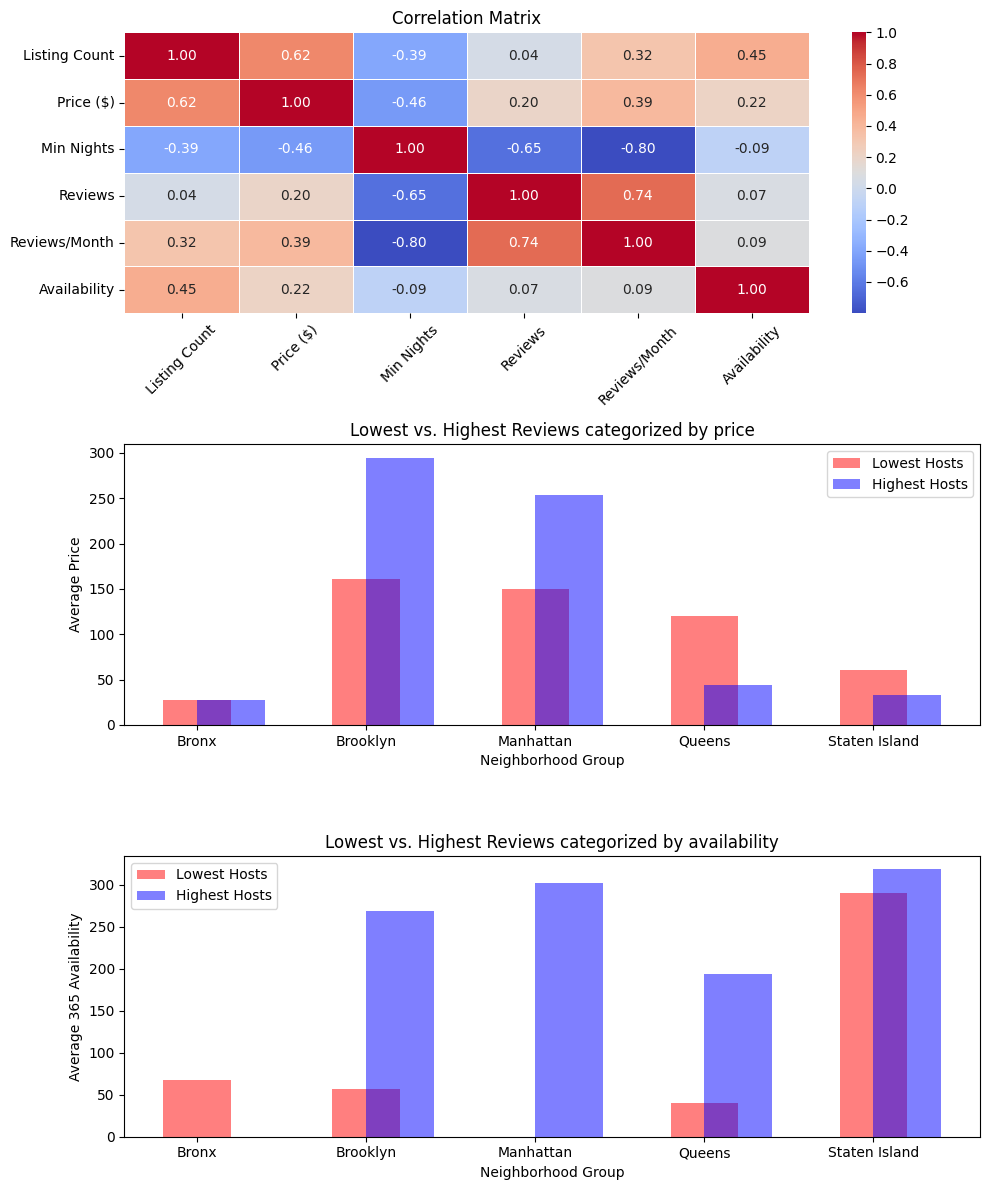

In [18]:
neighborhood_groups = df.groupby("neighbourhood_group")

tops = []
lowest = []

for group_name, group_df in neighborhood_groups:

    # this is getting the host listings for each host
    hosts = group_df.groupby("host_name")["calculated_host_listings_count"].max()

    # after we do that, we sort the list of hosts in descending order and grab the one with the most listings
    sorted_hosts = hosts.sort_values(ascending=False)

    top_host = sorted_hosts.index[0]  # Host name
    top_listings = int(sorted_hosts.iloc[0])

    # we do the same thing to keep track of the worst hosts in each neighborhood group
    lowest_hosts = group_df.groupby("host_name")["calculated_host_listings_count"].min()
    sorted_lowest = lowest_hosts.sort_values()

    lowest_host = sorted_lowest.index[0]
    lowest_listings = int(sorted_lowest.iloc[0])

    tops.append((group_name, top_host, top_listings))
    lowest.append((group_name, lowest_host, lowest_listings))


# we are converting the tops list into a dataframe corresponding to the correct columns in the data
top_hosts_df = pd.DataFrame(tops, columns=["neighbourhood_group", "host_name", "calculated_host_listings_count"])

# merge with the original DataFrame to get the rest of the columns for the associated rows in top_hosts
merged_df = df.merge(top_hosts_df, on=["neighbourhood_group", "host_name",
                                       "calculated_host_listings_count"], how="inner")

# do the same thing with the bottom hosts
lowest_hosts_df = pd.DataFrame(lowest, columns=["neighbourhood_group", "host_name",
                                                "calculated_host_listings_count"])

# merge with the original DataFrame to get additional features
lowest_merged = df.merge(lowest_hosts_df, on=["neighbourhood_group",
 "host_name", "calculated_host_listings_count"], how="inner")

# select relevant features
features = ["calculated_host_listings_count", "price", "minimum_nights",
            "number_of_reviews", "reviews_per_month", "availability_365"]

# plot heatmap of correlation coefficients
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

lowest_price = lowest_merged.groupby("neighbourhood_group")["price"].mean()
highest_price = merged_df.groupby("neighbourhood_group")["price"].mean()

lowest_availability = lowest_merged.groupby("neighbourhood_group")["availability_365"].mean()
highest_availability = merged_df.groupby("neighbourhood_group")["availability_365"].mean()

ax[1].bar(lowest_price.index, lowest_price.values, label="Lowest Hosts", color='red',
          alpha=0.5, width=0.4, align='center')
ax[1].bar(highest_price.index, highest_price.values, label="Highest Hosts", color='blue',
          alpha=0.5, width=0.4, align='edge')


"""

plotting the hosts with the highest number of listings and the host with lowest number
of listings in each neighborhood group against each other in terms of average
price

"""

ax[1].set_xlabel("Neighborhood Group")
ax[1].set_ylabel("Average Price")
ax[1].set_title("Lowest vs. Highest Reviews categorized by price")
ax[1].legend()

ax[2].bar(lowest_availability.index, lowest_availability.values, label="Lowest Hosts",
          color='red', alpha=0.5, width=0.4, align='center')
ax[2].bar(highest_availability.index, highest_availability.values, label="Highest Hosts",
          color='blue', alpha=0.5, width=0.4, align='edge')

"""

plotting the hosts with the highest number of listings and the host with lowest number
of listings in each neighborhood group against each other in terms of average
365 day availability

"""
ax[2].set_xlabel("Neighborhood Group")
ax[2].set_ylabel("Average 365 Availability")
ax[2].set_title("Lowest vs. Highest Reviews categorized by availability")
ax[2].legend()


merged_df = merged_df[features]

# renaming some of the columns for readability on the plots
rename_dict = {
    "calculated_host_listings_count": "Listing Count",
    "price": "Price ($)",
    "minimum_nights": "Min Nights",
    "number_of_reviews": "Reviews",
    "reviews_per_month": "Reviews/Month",
    "availability_365": "Availability",
}

new_merged = merged_df.rename(columns=rename_dict)

correlation_matrix = new_merged.corr(method='pearson')

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0)
ax[0].set_title("Correlation Matrix")

plt.tight_layout()
plt.show()




From the heatmap we can see that the feature which has the highest positive correlation with
the number of calculated_host_listings is the price. This means that typically, if a host
has a higher number of listings the price of the Airbnbs tend to be higher as well. We can
also see this from the first bar plot which plots the hosts w.r.t to the price, where in all of the Neighborhood groups other than Queens
and Staten Island, hosts with the greater amount of listings had a higher average price
when compared to the hosts which had the lowest amount of listings in the same neighborhood group.
From the second bar plot which shows the availability for the top and low hosts, we can see
that availability also plays a big part as the top hosts typically had a much greater
availability for their Airbnbs than the hosts with a low number of listings


Task 7


<ipython-input-19-5aab24ba3c6e>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
<ipython-input-19-5aab24ba3c6e>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)


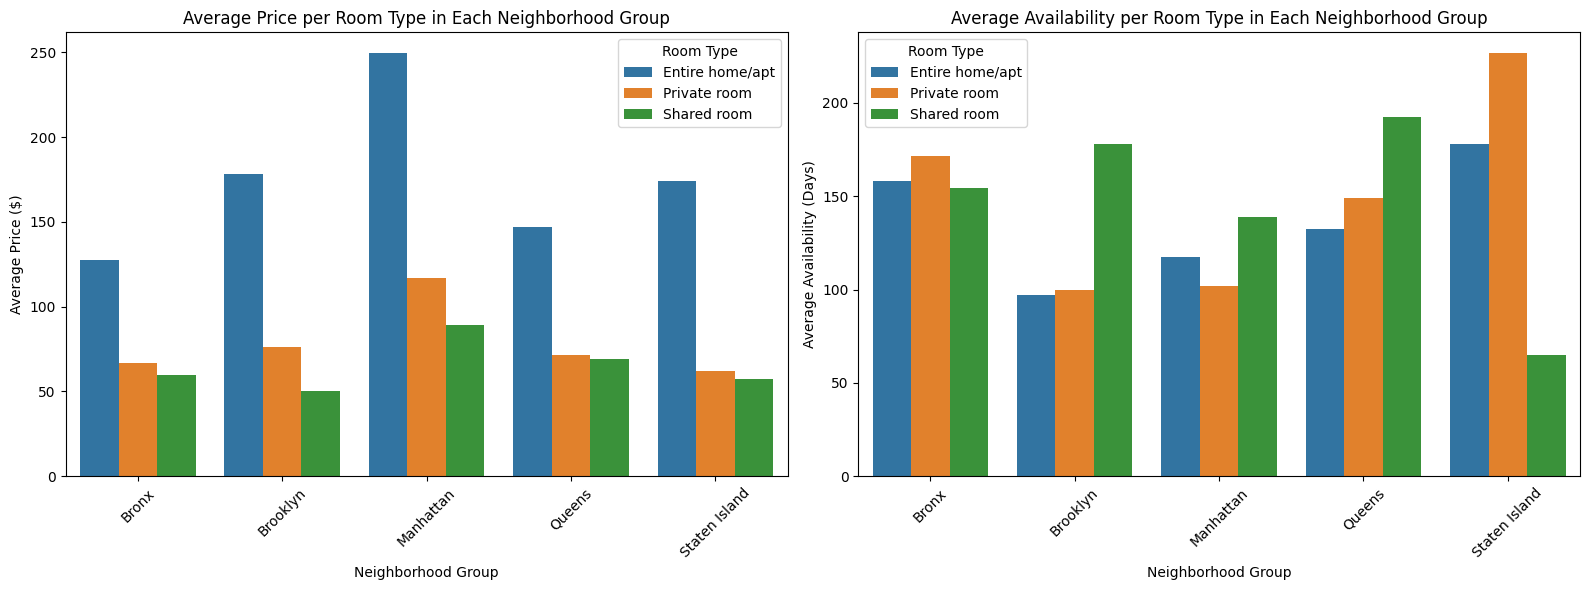

In [19]:
# group by neighborhood group and room_type and find the avg price
avg_prices_df = df.groupby(["neighbourhood_group", "room_type"])["price"].mean().reset_index()

avg_availability_df = df.groupby(["neighbourhood_group", "room_type"])["availability_365"].mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot Average Price
sns.barplot(data=avg_prices_df, x="neighbourhood_group", y="price", hue="room_type", ax=ax[0])
ax[0].set_xlabel("Neighborhood Group")
ax[0].set_ylabel("Average Price ($)")
ax[0].set_title("Average Price per Room Type in Each Neighborhood Group")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].legend(title="Room Type")

# Plot Average Availability
sns.barplot(data=avg_availability_df, x="neighbourhood_group", y="availability_365",
            hue="room_type", ax=ax[1])
ax[1].set_xlabel("Neighborhood Group")
ax[1].set_ylabel("Average Availability (Days)")
ax[1].set_title("Average Availability per Room Type in Each Neighborhood Group")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].legend(title="Room Type")

plt.tight_layout()
plt.show()




This plot allows us to see how the average prices of different room types varies for each neighbourhood group.
We can see that throughout all of the groups, the "Entire Home" room type is always the most expensive, next is
"Private Room", followed closely by "Shared Room" and we can see how these prices change between the groups with
Manhattan having the highest price for each room type, followed by Brooklyn. In the other bar plot which graphs the
365_availability against the Room Type across the neighborhood groups, this aims to find out how the average
availability varies according to room type and across each neighborhood group. We can see that the general trend
is that Entire Home < Private Room < Shared Room, but we can see this change in some neighborhood groups like Staten
Island where the availability of Shared Rooms is significantly less than the availability for Entire Homes or Private Rooms.
Another interesting thing to note is that in the Bronx we can see that all of the room types have very similar availability,
a phenomenon that is not seen in any of the other groups
